![picture](https://www.ifsc.edu.br/documents/1035121/12422695/snct22.png/98414174-41b4-41f1-a8c9-3c70cac512ea?t=1661898737261)

#Fazendo o download do dataset com os sinais de EMG
O dataset original encontra-se em https://archive.ics.uci.edu/ml/datasets/EMG+data+for+gestures.  
**Informação**   
Cada arquivo txt contém 10 colunas:  
[1] Time - tempo iem ms;  
[2-9] Channel - oito canais do bracelete MYO;  
[10] Class  -Classe correpondente aos gestos:  
0 - dado não marcado,  
1 - mão em estado de repouso,  
2 - mão fechada em formato de punho,  
3 - flexão do punho,  
4 - extensão do punho,  
5 - desvio radial,  
6 - desvio ulnar,  
7 - palma estendida (este gesto não foi executado por alguns sujeitos).  

![picture](http://tocupacional.files.wordpress.com/2008/08/clip-image010.jpg)

In [1]:
!wget https://github.com/samirbonho/IFSC/raw/master/EMG_data_for_gestures_master.zip -O emg.zip
!unzip "/content/emg.zip" 
!rm  "/content/emg.zip" 

#!unzip /content/drive/MyDrive/IFSC/SNCT/EMG/EMG_data_for_gestures-master.zip 

--2022-10-25 16:51:42--  https://github.com/samirbonho/IFSC/raw/master/EMG_data_for_gestures_master.zip
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/samirbonho/IFSC/master/EMG_data_for_gestures_master.zip [following]
--2022-10-25 16:51:42--  https://raw.githubusercontent.com/samirbonho/IFSC/master/EMG_data_for_gestures_master.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15473410 (15M) [application/zip]
Saving to: ‘emg.zip’

emg.zip             100%[===================>]  14.76M  --.-KB/s    in 0.1s    

2022-10-25 16:51:43 (131 MB/s) - ‘emg.zip’ saved [15473410/15473410]

Archive:  /co

#Verificando se os registros contém os dados dos eletrodos.
No exemplo abaixo é feito um gráfico com os dados coletados do canal 1

<function matplotlib.pyplot.grid(b=None, which='major', axis='both', **kwargs)>

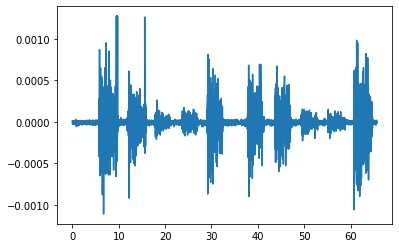

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

  
# read text file into pandas DataFrame
df = pd.read_csv("/content/EMG_data_for_gestures_master/01/1_raw_data_13-12_22.03.16.txt", sep="\t")
df.head(3)

canal1=df[["time","channel1","class"]]
time = canal1.iloc[:,[0]].values
emgCH1 = canal1.iloc[:,[1]].values
classes= canal1.iloc[:,-1].values

plt.plot(time/1000,emgCH1)
plt.grid


#Criando um dataframe a partir de todos os arquivos de registro dos 36 sujeitos, cada qual com informações dos 8 pares de eletrodos (8 canais)

In [3]:
import os,glob
import pandas as pd
import numpy as np

counter=0
folder = "/content/EMG_data_for_gestures_master/"
resultados = []

#pd.concat([s1, s2], ignore_index=True)
dataset = pd.DataFrame()
subject_rows=[]
aux=0

for root, dirs, files in os.walk(folder, topdown=False):
  subject_n=root.rsplit('master/', 1)[1]
  for name in files:
    df = pd.read_csv(os.path.join(root, name), sep="\t")

    for i in range(1,7):    
      # df[df['class']==i].iloc[:,1:9] = (df[df['class']==i].iloc[:,1:9] - (df[df['class']==i].iloc[:,1:9].min())) / ((df[df['class']==i].iloc[:,1:9].max()) - (df[df['class']==i].iloc[:,1:9].min()))
      df[df['class']==i].iloc[:,1:9] = ( df[df['class']==i].iloc[:,1:9] - ( df[df['class']==i].iloc[:,1:9].min()).min()) / (( df[df['class']==i].iloc[:,1:9].max()).max() - ( df[df['class']==i].iloc[:,1:9].min()).min())

    frames = [dataset,df]
    dataset=pd.concat(frames, ignore_index=True)
    dataset.loc[aux:(aux+df.shape[0]),'subject'] = subject_n
    aux=aux+df.shape[0]

dataset['subject'].astype(str).astype(int)  #converting Object to int
dataset.drop('time',inplace=True,axis=1) #eliminando a coluna de tempo

dataset['subject'].value_counts()
len(dataset['subject'].value_counts())

## eliminando os registros com a classe 7 (palma estendida) e classe 0
dataset=dataset[dataset['class']!=7.0] 
dataset=dataset[dataset['class']!=0.0] 

dataset['class'].value_counts()


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1851: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, val, pi)


6.0    253009
5.0    251733
4.0    251570
1.0    250055
3.0    249494
2.0    243193
Name: class, dtype: int64

#Métodos para extrair características dos sinais elétricos
Estas caracterísicas serão utilizadas pelos classificadores para identificação do gesto.

In [4]:
import numpy as np

def rms(data): #root mean square
      return  np.sqrt(np.mean(data**2,axis=0))  

def abs_diffs_signal(data):
    return np.sum(np.abs(np.diff(data,axis=0)),axis=0)

def zero_crossing(data):
    return np.count_nonzero(np.diff(np.sign(data),axis=0))


#Extração de features
Dependendo das features calculadas/extraidas a performance do classificador pode melhorar ou não!

In [5]:
sujeitos_dados=dataset.groupby(['subject','class'])
sujeitos_dados.head()

features=sujeitos_dados.agg([zero_crossing])
features=features.reset_index()
features['subject']=features['subject'].astype(str).astype(int)  #converting Object to int

features.head(9) 

,subject,class,channel1,channel2,channel3,channel4,channel5,channel6,channel7,channel8
,,,zero_crossing,zero_crossing,zero_crossing,zero_crossing,zero_crossing,zero_crossing,zero_crossing,zero_crossing
0,1,1.0,404,415,455,442,387,339,389,377
1,1,2.0,366,388,382,391,376,377,357,393
2,1,3.0,375,400,425,430,423,389,388,356
3,1,4.0,371,362,357,350,331,348,362,356
4,1,5.0,437,426,406,376,375,375,409,427
5,1,6.0,412,413,431,427,395,401,415,400
6,2,1.0,451,468,481,444,438,444,445,415
7,2,2.0,451,454,416,409,425,397,427,454
8,2,3.0,403,453,438,428,404,396,415,403


#Algoritmos de Classificação

In [6]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,accuracy_score,recall_score,roc_auc_score, precision_score,f1_score,confusion_matrix
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

#Criando uma lista de classificadores
Pode-se modificar os hiperparâmetros de cada classificador para uma melhora das métricas

In [7]:
classifiers = [
    KNeighborsClassifier(metric='manhattan',weights='distance',n_neighbors=4),
    SVC(C=3, gamma=0.04),
    DecisionTreeClassifier(criterion= 'entropy',max_depth= 7,max_features= 'auto',random_state= 20),
    RandomForestClassifier(bootstrap=False,max_depth=8,max_features='sqrt',min_samples_leaf=1,
                          min_samples_split=2,n_estimators=100),
    LogisticRegression(C=0.05, penalty='l2')]

#Treinando os classificadores a partir do dataframe
Cada sujeito realizou 6 gestos com a mão. Para cada gesto (classe), foram definidos 5 features extraidas dos sinais elétricos de cada canal.
Logo são 8 canais x 5 features ('min','max',rms,zero_crossing,abs_diffs_signal) = 40 características para cada um dos gestos

In [8]:
import warnings
from time import time
import joblib


warnings.filterwarnings('always') 
clf_performace={'accuracy':[],'f1score':[]}


for clfs in classifiers:
    name = clfs.__class__.__name__
    filename = name + '.sav'
    accuracy=[]
    f1score=[]
    acc_=0
    for i in range(1,len(features['subject'].value_counts())):
        train=features[features['subject']!=i]
        test=features[features['subject']==i]
        X_train=train.iloc[:,2::].values #trabalha com as 40 features (5 features nos 8 canais)
        X_test=test.iloc[:,2::].values

        scaler = StandardScaler()                  #z = (x - u) / s   u->media e s->desvio padrão
        X_train=scaler.fit_transform(X_train) 
        X_test=scaler.fit_transform(X_test)

        y_train=train['class']
        y_test=test['class']
        #clf = make_pipeline(StandardScaler(), clfs)
        clf = make_pipeline(clfs)

        clf.fit(X_train, y_train)
        y_pred=clf.predict(X_test)
        f1score.append(f1_score(y_test,y_pred,average='macro'))
        acc=accuracy_score(y_test,y_pred)
        accuracy.append(acc)
        if acc>acc_:          
          joblib.dump(clf, filename)
          acc_=acc
              
        #print('Sujeito {}: acuracia = {}'.format(i,acc))
    print(name,np.mean(accuracy))
    clf_performace['accuracy'].append(accuracy)
    clf_performace['f1score'].append(f1score)


KNeighborsClassifier 0.4619047619047618
SVC 0.5333333333333333
DecisionTreeClassifier 0.3714285714285714
RandomForestClassifier 0.4714285714285714
LogisticRegression 0.5


#Métricas da classificação

In [9]:
a=np.mean(np.array(clf_performace['accuracy']),axis=1)
f=np.mean(np.array(clf_performace['f1score']),axis=1)

df=pd.DataFrame(np.stack((a,f)),columns=['KNN','SVM','DT','RF','LR'],
            index=['Accuracy','F1-score'])
df

,KNN,SVM,DT,RF,LR
Accuracy,0.461905,0.533333,0.371429,0.471429,0.500000
F1-score,0.378571,0.457143,0.296825,0.385714,0.423016
